In [10]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
%matplotlib inline
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:80% !important; }</style>")) 

# Load Tags Data

In [11]:
# Load index mapping 
with open('../data/movie_to_idx.pkl', 'rb') as handle:
    movie2idx = pickle.load(handle)

In [12]:
#load tags and ratings data
cwd = os.getcwd()
tags = pd.read_csv(os.path.join(cwd, "..", "data", "tags.csv"))
print("{} unique movies in tags.csv".format(len(tags.movieId.unique())))
ratings = pd.read_csv(os.path.join(cwd, "..", "data", "ratings.csv"))
ratings = ratings.drop_duplicates('movieId')
print("{} unique movies in ratings.csv".format(len(ratings.movieId.unique())))

19545 unique movies in tags.csv
26744 unique movies in ratings.csv


In [13]:
#map movie index for tags data
tags = pd.merge(tags, ratings, on="movieId", how="right")
tags.movieId = tags.movieId.apply(lambda x: movie2idx[x])
print("{} unique movies in tags.csv".format(len(tags.movieId.unique())))
print(tags.shape)
tags.head()

26744 unique movies in tags.csv
(472537, 7)


,userId_x,movieId,tag,timestamp_x,userId_y,rating,timestamp_y
0,18.0,3135,Mark Waters,1.240597e+09,103,3.5,1055018362
1,66193.0,3135,naive,1.294446e+09,103,3.5,1055018362
2,70201.0,3135,Mark Waters,1.308333e+09,103,3.5,1055018362
3,89274.0,3135,Freddie Prinze Jr.,1.375164e+09,103,3.5,1055018362
4,65.0,639,dark hero,1.368150e+09,8,3.0,833981834


In [14]:
#map movie index for movie data
movies = pd.read_csv(os.path.join(cwd, "..", "data", "movies.csv"))
print("{} unique movies in movies.csv".format(len(movies.movieId.unique())))
print("{} unique movies in ratings.csv".format(len(ratings.movieId.unique())))

movies = pd.merge(movies, ratings, on="movieId", how="inner")
movies.movieId = movies.movieId.apply(lambda x: movie2idx[x])
print("{} unique movies in movies.csv".format(len(movies.movieId.unique())))

movies.set_index('movieId', inplace=True)
movies['genres'] = movies['genres'].str.replace(pat="|", repl=" ")
movies['genres'] = movies['genres'].str.replace(pat="-", repl="")
movies.query('title == "Primer (2004)"')

27278 unique movies in movies.csv
26744 unique movies in ratings.csv
26744 unique movies in movies.csv


,title,genres,userId,rating,timestamp
movieId,,,,,
3006,Primer (2004),Drama SciFi,96,4.5,1402187423


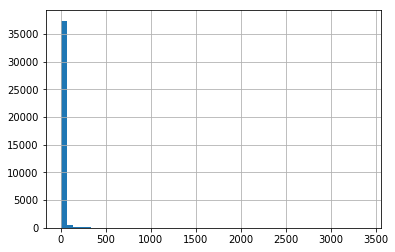

In [15]:
tags.tag.value_counts().hist(bins=50)

In [19]:
#create documents from tags
tags.fillna("", inplace=True)
tags = pd.DataFrame(tags.groupby('movieId')['tag'].apply(lambda x: "{%s}" % ' '.join(x)))
tags.reset_index(inplace=True)
movie_id = tags.movieId
print("There are {} unique movies".format(len(movie_id)))
tags.sample(10)

There are 26744 unique movies


,movieId,tag
13063,13063,{jonny weston surfing}
1113,1113,{sport:basketball sports competition basketbal...
13203,13203,{less than 300 ratings Navy U.S.S. Kearsarge (...
420,420,{Greg Kinnear romance remadeAs:Sabrina(1995) r...
9274,9274,{gay agenda gender ambiguity loneliness pathet...
1896,1896,{family secrets dogma dark comedy dogme95 ince...
8844,8844,{my child let me show you how firm my faith is...
1010,1010,{movie to see enjoyable enjoyable good laughs ...
19849,19849,{}
7080,7080,{atmospheric claustrophobic disturbing face go...


In [20]:
# add genres to document
tags = pd.merge(movies, tags, left_index=True, right_on='movieId', how='right')
tags['document'] = tags[['tag', 'genres']].apply(lambda x: ' '.join(x), axis=1)
tags.head(3)

,title,genres,userId,rating,timestamp,movieId,tag,document
0,Jumanji (1995),Adventure Children Fantasy,1,3.5,1112486027,0,{time travel adapted from:book board game chil...,{time travel adapted from:book board game chil...
1,"City of Lost Children, The (Cité des enfants p...",Adventure Drama Fantasy Mystery SciFi,1,3.5,1112484676,1,{children Santa Claus dystopia abused children...,{children Santa Claus dystopia abused children...
2,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery SciFi Thriller,1,3.5,1112484819,2,{post-apocalyptic psychology time travel Brad ...,{post-apocalyptic psychology time travel Brad ...


In [ ]:
tags.query('title == "Zodiac (2007)"').document.values

In [21]:
tags.query('movieId == 19849')

,title,genres,userId,rating,timestamp,movieId,tag,document
19849,"Waiting Game, The (2000)",Comedy,29879,2.5,1161368462,19849,{},{} Comedy


# TFIDF
Vectorize tags and genres into unigrams and bigrams with the TFIDF tokenizer.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2),
                        min_df=0.0002,
                        stop_words='english')
tfidf_matrix = tfidf.fit_transform(tags.document)
print(tfidf_matrix.shape)

(26744, 14518)


In [31]:
tfidf.vocabulary_

{'time': 13147,
 'travel': 13371,
 'adapted': 502,
 'book': 1900,
 'board': 1857,
 'game': 5837,
 'childhood': 2677,
 'cgi': 2523,
 'animals': 894,
 'scary': 11498,
 'fantasy': 5132,
 'robin': 11152,
 'williams': 14229,
 'joe': 7377,
 'johnston': 7432,
 'kid': 7650,
 'flick': 5470,
 'jungle': 7526,
 'adventure': 544,
 'children': 2686,
 'dynamic': 4538,
 'action': 373,
 'kirsten': 7725,
 'dunst': 4448,
 'childish': 2682,
 'filmed': 5411,
 'bc': 1509,
 'bad': 1372,
 'based': 1469,
 'chris': 2726,
 'van': 13693,
 'magic': 8333,
 'monkey': 8900,
 'saturn': 11482,
 'award': 1335,
 'best': 1641,
 'special': 12219,
 'effects': 4650,
 'supporting': 12736,
 'actress': 474,
 'clv': 3010,
 'horrifying': 6690,
 'horror': 6692,
 'genre': 5930,
 'kids': 7660,
 'time travel': 13156,
 'adapted book': 503,
 'board game': 1858,
 'cgi animals': 2525,
 'time time': 13155,
 'robin williams': 11154,
 'joe johnston': 7380,
 'kid flick': 7652,
 'travel adventure': 13373,
 'children fantasy': 2698,
 'dynamic 

In [33]:
path = "../data/"
with open(f'{path}tfidf_matrix.pkl', 'wb') as fh:
    tfidf_matrix = pickle.dump(path, fh)